## Importação de libs

In [2]:
# para ler arquivo excel (xls)
# conda install -c anaconda xlrd

import datetime
from datetime import datetime
import os

# Analise
import pandas as pd 
import numpy as np 

#Visualization
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import plotly
import plotly.express as px

## Parâmetros

In [4]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
pd.set_option('max_colwidth', 1000) # tamanho das colunas para exibição do conteúdo de textos longos

np.set_printoptions(threshold=1000)

# Formatar numeros float (2 casas decimais)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# Formatações para gráficos
sns.set(style="darkgrid") #cor da area dos plots
figsize = (10,10)

carga dos dados das ies federais já filtradas e com os dados do IBGE- gerado pela renata

In [17]:
list_col_string = ['CO_IES'] 
dict_dtype = {column : 'str'  for column in list_col_string}

ies = pd.read_csv('../arquivos/dados_ies_consolidado.csv', sep ='|',
                  dtype = dict_dtype, low_memory=False)

ies = ies[ies['TP_CATEGORIA_ADMINISTRATIVA'] == 1]
ies = ies[['CO_IES', 'NO_IES', 'SG_IES' ]]
ies.head()


,CO_IES,NO_IES,SG_IES
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,UFMT
6,3164,"INSTITUTO FEDERAL DE EDUCAÇÃO, CIÊNCIA E TECNOLOGIA DE MATO GROSSO",IFMT
25,2,UNIVERSIDADE DE BRASÍLIA,UNB
68,14408,"INSTITUTO FEDERAL DE EDUCAÇÃO, CIENCIA E TECNOLOGIA DE BRASILIA",IFB
70,16037,Instituto Superior de Ciencias Policiais,ISCP


Carga dos cursos de 2022 e filtro para pegar só as federais     

In [117]:
%%time

# definir os tipos de algumas colunas 
# facilita operações de merge (tem que conter os mesmos tipos de dados)
list_col_string = ['CO_REGIAO', 'CO_UF', 'CO_MUNICIPIO', 'CO_CURSO', 'CO_CINE_ROTULO',
                   'CO_CINE_AREA_GERAL','CO_CINE_AREA_ESPECIFICA','CO_CINE_AREA_DETALHADA','CO_IES'] 
dict_dtype = {column : 'str'  for column in list_col_string}

df_cursos = pd.read_csv('../arquivos/MICRODADOS_CADASTRO_CURSOS_2022.CSV', 
                          dtype = dict_dtype,
                          sep=';',
                          encoding='iso-8859-1',
                          low_memory=False)

df_cursos = df_cursos[df_cursos['TP_CATEGORIA_ADMINISTRATIVA']==1]
df_cursos = df_cursos[df_cursos['TP_MODALIDADE_ENSINO']==1]

df_cursos = df_cursos.drop(['TP_DIMENSAO','TP_CATEGORIA_ADMINISTRATIVA','TP_REDE', 'IN_GRATUITO',\
                            'QT_ING_FINANC','QT_ING_FINANC_REEMB','QT_ING_FIES','QT_ING_RPFIES','QT_ING_FINANC_REEMB_OUTROS','QT_ING_FINANC_NREEMB','QT_ING_PROUNII','QT_ING_PROUNIP',\
                            'QT_ING_NRPFIES','QT_ING_FINANC_NREEMB_OUTROS','QT_MAT_FINANC','QT_MAT_FINANC_REEMB','QT_MAT_FIES','QT_MAT_RPFIES','QT_MAT_FINANC_REEMB_OUTROS','QT_MAT_FINANC_NREEMB','QT_MAT_PROUNII','QT_MAT_PROUNIP',\
                            'QT_MAT_NRPFIES','QT_MAT_FINANC_NREEMB_OUTROS','QT_CONC_FINANC','QT_CONC_FINANC_REEMB','QT_CONC_FIES','QT_CONC_RPFIES','QT_CONC_FINANC_REEMB_OUTROS','QT_CONC_FINANC_NREEMB','QT_CONC_PROUNII',	\
                            'QT_CONC_PROUNIP','QT_CONC_NRPFIES','QT_CONC_FINANC_NREEMB_OUTROS'  ], axis=1)



CPU times: total: 14.2 s
Wall time: 37.5 s


cidades com Micro regiões IBGE - e populacao

In [118]:
list_col_string = ['COD_IBGE' ] 
dict_dtype = {column : 'str'  for column in list_col_string}

df_micro_reg = pd.read_csv('../arquivos/dados_ibge_consolidado.CSV', sep = '|',
                          dtype = dict_dtype,
                          low_memory=False)


juntar cursos com ies 


In [119]:
df_cursos_ies_ibge = df_cursos.merge(ies, how= 'inner', left_on='CO_IES', right_on='CO_IES')


juntar cursos com micro regioes

In [120]:
df_cursos_ies_ibge = df_cursos_ies_ibge.merge(df_micro_reg, how= 'inner', left_on='CO_MUNICIPIO', right_on='COD_IBGE')

Verificar Proporção de Matriculados em Relação à População por Região

In [121]:
t2 = df_cursos_ies_ibge.groupby(['COD_IBGE','LAT', 'LNG','REGIAO', 'SIGLA_UF','NOME_UF',  \
                                 'Cod_Mesorregiao',	'Nome_Mesorregiao','Cod_Microrregiao','Nome_Microrregiao','NOME_MUNICIPIO'])\
    .agg({'CO_CURSO':'count', 'QT_VG_NOVA': 'sum', 'QT_MAT': 'sum', 'POP_IBGE_2022':'max', 'CO_IES':'nunique'}).reset_index()

t2 = t2.rename(columns={'CO_CURSO':'NUM_CURSOS', 'QT_VG_NOVA':'NUM_VAGAS_ANO','POP_IBGE_2022':'POPULACAO', 'QT_MAT': 'NUM_MATRICULADOS', 'CO_IES':'NUM_IES'})
t2['Nome_Mesorregiao'] = t2['REGIAO'] + ' (' + t2['NOME_UF'] + ')' + ' - ' + t2['Nome_Mesorregiao'] 


C:\Users\giluc\AppData\Local\Temp\ipykernel_12216\1452449026.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




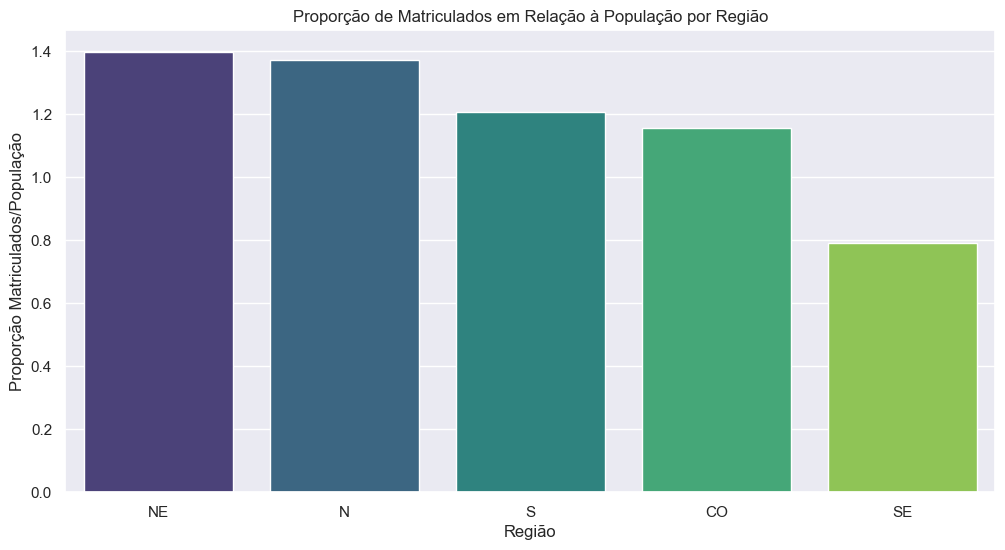

In [157]:

t3 = t2[['REGIAO','NUM_CURSOS','NUM_VAGAS_ANO','NUM_MATRICULADOS','POPULACAO', 'NUM_IES']].groupby(['REGIAO'])\
    .agg({'NUM_CURSOS':'sum', 'NUM_VAGAS_ANO':'sum', 'NUM_MATRICULADOS':'sum', 'POPULACAO':'sum', 'NUM_IES': 'nunique'}).reset_index()
t3['prop_matr_pop'] = (t3['NUM_MATRICULADOS']/t3['POPULACAO'])*100

# Ordenar por proporção
t3 = t3.sort_values(by='prop_matr_pop', ascending=False)

# Criar um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=t3, y='prop_matr_pop', x='REGIAO', palette='viridis')
plt.xlabel('Região')
plt.ylabel('Proporção Matriculados/População')
plt.title('Proporção de Matriculados em Relação à População por Região')
plt.show()

Verificar a proporção de vagas novas em relação a populacao

C:\Users\giluc\AppData\Local\Temp\ipykernel_12216\908745825.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=t3, y='prop_vagas_pop', x='REGIAO', palette='viridis')


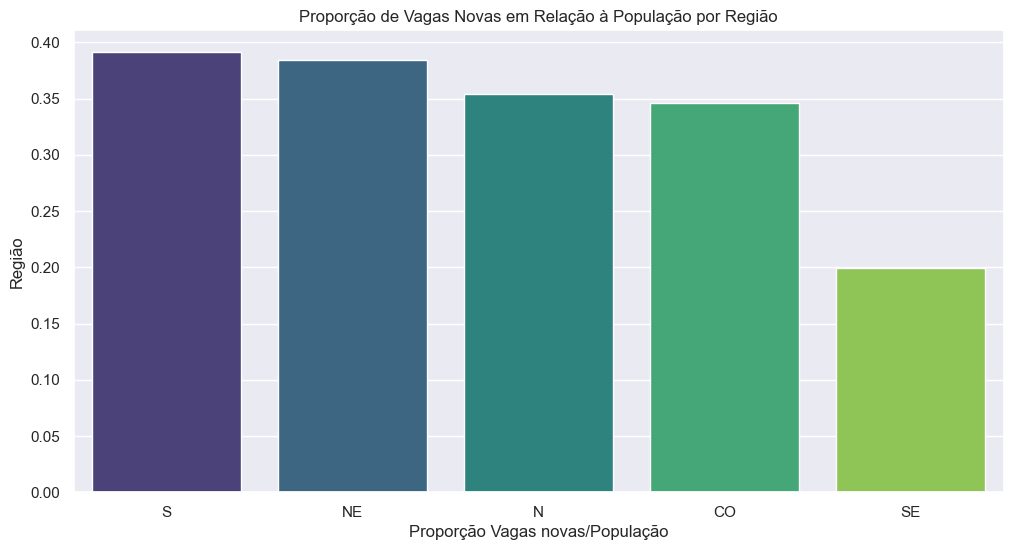

In [123]:
t3['prop_vagas_pop'] = (t3['NUM_VAGAS_ANO']/t3['POPULACAO'])*100

# Ordenar por proporção
t3 = t3.sort_values(by='prop_vagas_pop', ascending=False)

# Criar um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=t3, y='prop_vagas_pop', x='REGIAO', palette='viridis')
plt.xlabel('Proporção Vagas novas/População')
plt.ylabel('Região')
plt.title('Proporção de Vagas Novas em Relação à População por Região')
plt.show()

Verificar em quantas regiões intermediárias possuem IFES

Proporção de cidades e de microrregiões atendidas por ao menos uma IFES - por estado e por região

In [134]:
df_municipios = df_micro_reg.groupby(['REGIAO','NOME_UF']).agg({'POP_IBGE_2022': 'sum', 'COD_IBGE': 'nunique'}).reset_index()

df_municipios = df_municipios.rename(columns={'COD_IBGE':'NUM_CIDADES', 'POP_IBGE_2022':'POPULACAO'})

df_ies_municipio = df_cursos_ies_ibge.groupby(['REGIAO','NOME_UF']).agg({'COD_IBGE':'nunique', 'CO_IES': 'nunique'}).reset_index()
df_ies_municipio = df_ies_municipio.rename(columns = {'COD_IBGE':'NUM_CIDADES_COM_IES', 'CO_IES': 'NUM_IES'})

df_municipios =df_municipios.merge(df_ies_municipio, how='left', on=['REGIAO','NOME_UF'])

df_municipios = df_municipios.drop(df_municipios[df_municipios['NOME_UF'] == 'Distrito Federal'].index)

df_municipios['NOME_UF'] = df_municipios['REGIAO']  + '/' + df_municipios['NOME_UF'] 


  REGIAO  NUM_CIDADES  NUM_CIDADES_COM_IES  prop_cidades
4     SE         1668                  156          9.35
3      S         1191                  125         10.50
2     NE         1794                  186         10.37
1      N          450                   75         16.67
0     CO          466                   58         12.45


C:\Users\giluc\AppData\Local\Temp\ipykernel_12216\3892392507.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_municipios_regiao, y='prop_cidades', x='REGIAO', palette='viridis')


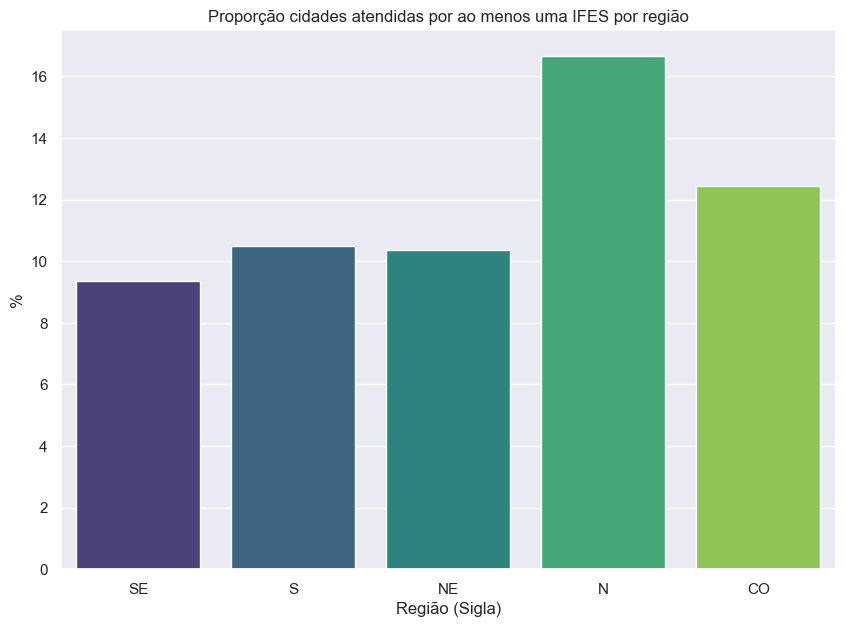

In [135]:

df_municipios_regiao = df_municipios.groupby('REGIAO').agg({'NUM_CIDADES': 'sum', 'NUM_CIDADES_COM_IES': 'sum'}).reset_index()
df_municipios_regiao['prop_cidades'] = (df_municipios_regiao['NUM_CIDADES_COM_IES']/ df_municipios_regiao['NUM_CIDADES'])*100

df_municipios_regiao = df_municipios_regiao.sort_values(by='REGIAO', ascending=False)
print(df_municipios_regiao)
# Criar um gráfico de barras
plt.figure(figsize=(10, 7))
sns.barplot(data=df_municipios_regiao, y='prop_cidades', x='REGIAO', palette='viridis')
plt.ylabel('%')
plt.xlabel('Região (Sigla)')
plt.title('Proporção cidades atendidas por ao menos uma IFES por região')
#plt.xticks(fontsize=8, rotation=30)
plt.show()

                   NOME_UF  NUM_CIDADES  NUM_CIDADES_COM_IES  prop_cidades
25            SE/São Paulo          645                   39          6.05
24       SE/Rio de Janeiro           92                   25         27.17
23         SE/Minas Gerais          853                   72          8.44
22       SE/Espírito Santo           78                   20         25.64
21        S/Santa Catarina          295                   35         11.86
20     S/Rio Grande do Sul          497                   53         10.66
19                S/Paraná          399                   37          9.27
18              NE/Sergipe           75                    8         10.67
17  NE/Rio Grande do Norte          167                   19         11.38
16                NE/Piauí          224                   17          7.59
15           NE/Pernambuco          185                   20         10.81
14              NE/Paraíba          223                   18          8.07
13             NE/Maranhã

C:\Users\giluc\AppData\Local\Temp\ipykernel_12216\392758394.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_municipios_estado, y='prop_cidades', x='NOME_UF', palette='viridis')


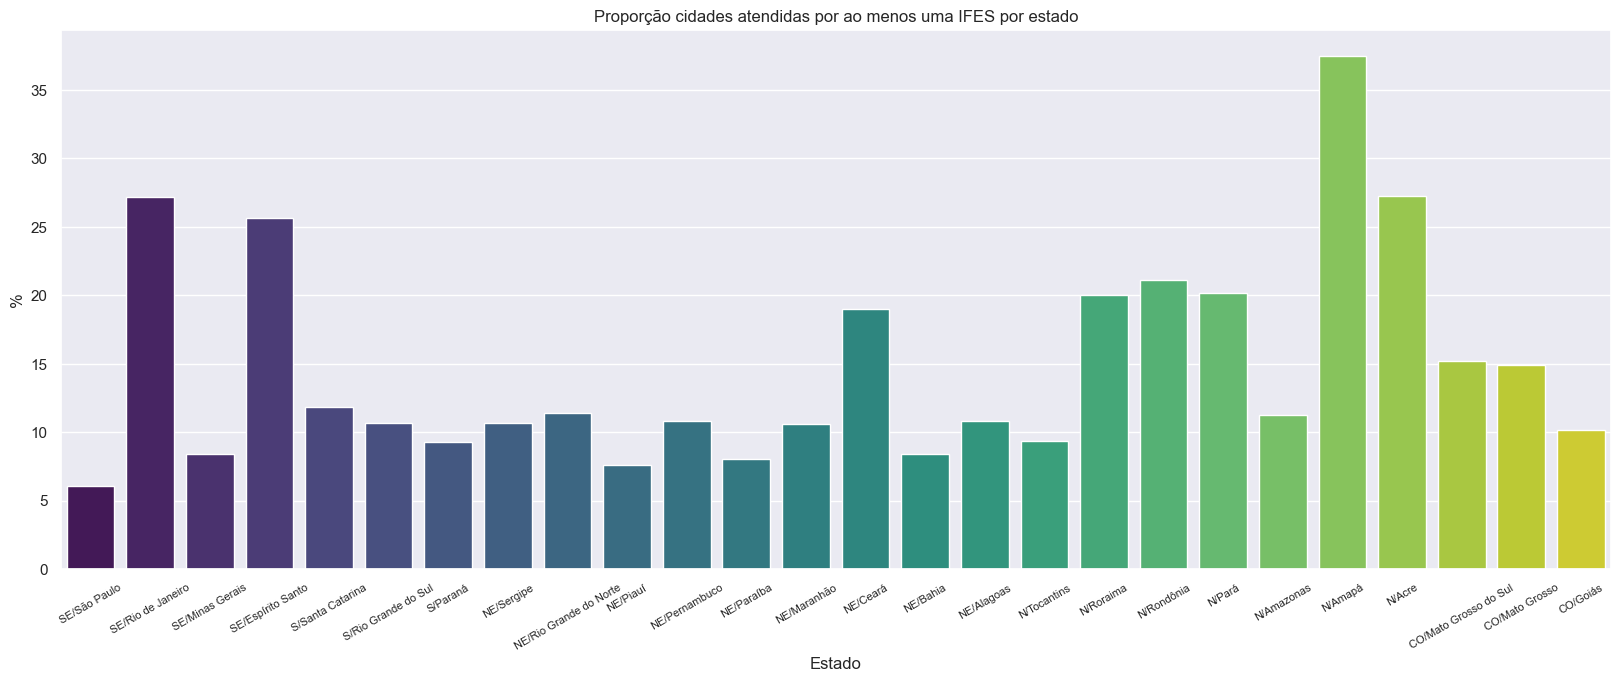

In [136]:
df_municipios_estado = df_municipios.groupby('NOME_UF').agg({'NUM_CIDADES': 'sum', 'NUM_CIDADES_COM_IES': 'sum'}).reset_index()
df_municipios_estado['prop_cidades'] = (df_municipios_estado['NUM_CIDADES_COM_IES']/ df_municipios_estado['NUM_CIDADES'])*100

df_municipios_estado = df_municipios_estado.sort_values(by='NOME_UF', ascending=False)
print(df_municipios_estado)
# Criar um gráfico de barras
plt.figure(figsize=(20, 7))
sns.barplot(data=df_municipios_estado, y='prop_cidades', x='NOME_UF', palette='viridis')
plt.ylabel('%')
plt.xlabel('Estado')
plt.title('Proporção cidades atendidas por ao menos uma IFES por estado')
plt.xticks(fontsize=8, rotation=30)
plt.show()

Microrregiões atendidas por ao menos uma IFES - por estado e por regiao

In [141]:

df_micro = df_micro_reg.groupby(['REGIAO','NOME_UF',  'Nome_Mesorregiao']).agg({ 'Nome_Microrregiao':'nunique','POP_IBGE_2022': 'sum', 'COD_IBGE': 'nunique'}).reset_index()
df_micro = df_micro.rename(columns={'COD_IBGE':'NUM_MUNICIPIOS', 'POP_IBGE_2022':'POPULACAO', 'Nome_Microrregiao':'NUM_MICRO_REG'})

df_ies_micro = df_cursos_ies_ibge.groupby(['REGIAO', 'NOME_UF',  'Nome_Mesorregiao']).agg({'COD_IBGE':'nunique', 'CO_IES': 'nunique', 'Nome_Microrregiao': 'nunique'}).reset_index()
df_ies_micro= df_ies_micro.rename(columns = {'COD_IBGE':'NUM_MUNICIPIOS_COM_IES', 'CO_IES': 'NUM_IES_MICRO', 'Nome_Microrregiao':'NUM_MICRO_REG_COM_IES'})

#df_micro[~df_micro['Nome_Microrregiao'].isin(df_ies_micro['Nome_Microrregiao'])]
#.groupby('NOME_UF').count()

df_micro_x_ies = df_micro.merge(df_ies_micro, how='left', on=['REGIAO', 'NOME_UF', 'Nome_Mesorregiao'])
df_micro_x_ies= df_micro_x_ies.fillna(0)
df_micro_x_ies = df_micro_x_ies.drop(df_micro_x_ies[df_micro_x_ies['NOME_UF'] == 'Distrito Federal'].index)
df_micro_x_ies['NOME_UF'] =  df_micro_x_ies['REGIAO'] + '/' +df_micro_x_ies['NOME_UF'] 



                   NOME_UF  NUM_MICRO_REG  POPULACAO  NUM_MICRO_REG_COM_IES  \
25            SE/São Paulo             63   46024937                  27.00   
24       SE/Rio de Janeiro             18   16615526                  15.00   
23         SE/Minas Gerais             66   20732660                  50.00   
22       SE/Espírito Santo             13    3975100                  12.00   
21        S/Santa Catarina             20    7762154                  17.00   
20     S/Rio Grande do Sul             35   11088065                  29.00   
19                S/Paraná             39   11835379                  24.00   
18              NE/Sergipe             13    2211868                   7.00   
17  NE/Rio Grande do Norte             19    3303953                  14.00   
16                NE/Piauí             15    3270174                  13.00   
15           NE/Pernambuco             19    9051113                  12.00   
14              NE/Paraíba             23    4030961

C:\Users\giluc\AppData\Local\Temp\ipykernel_12216\3634107867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_estado, y='prop_micro_com_ies', x='NOME_UF', palette='viridis')


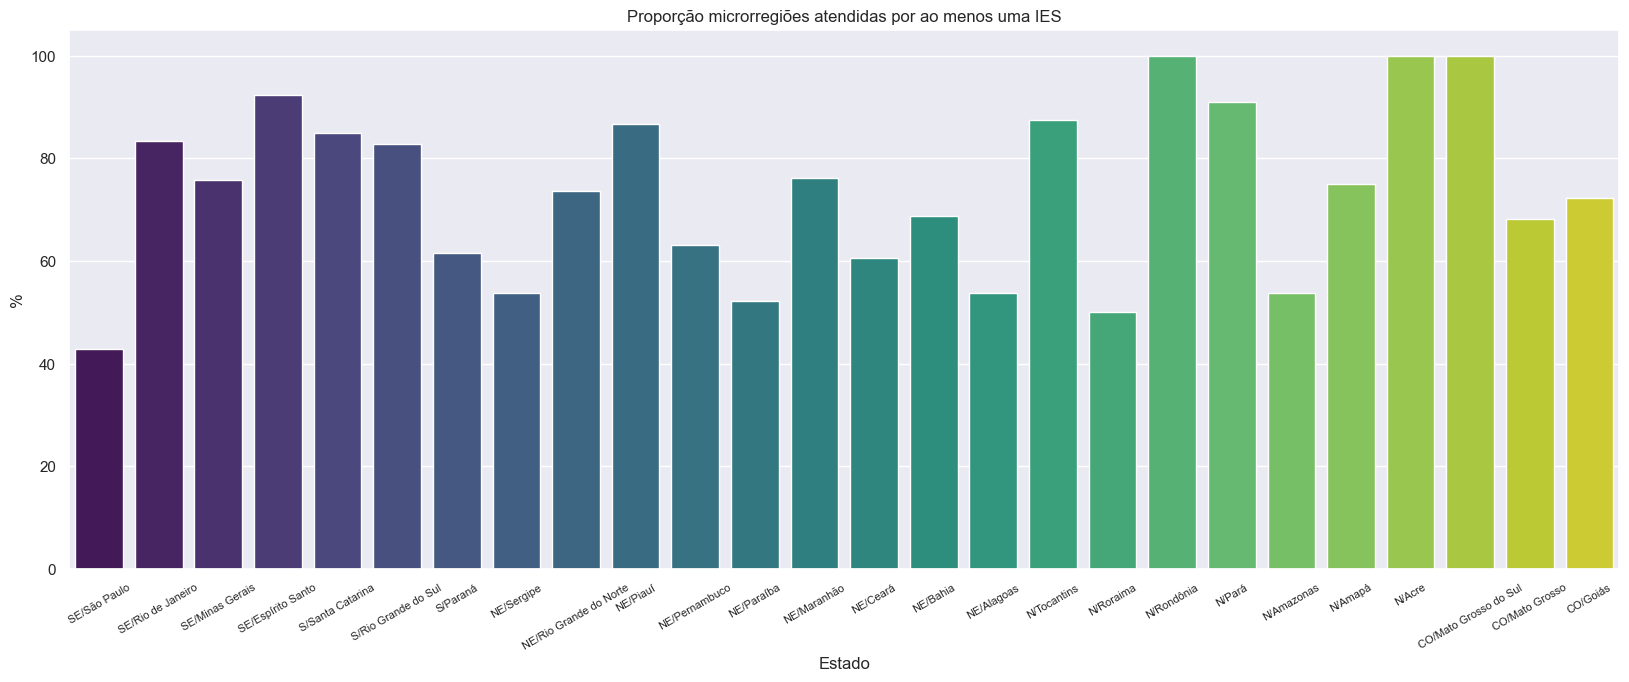

In [145]:

df_estado= df_micro_x_ies.groupby('NOME_UF').agg({'NUM_MICRO_REG': 'sum', 'POPULACAO':'sum', 'NUM_MICRO_REG_COM_IES': 'sum'}).reset_index()
df_estado['prop_micro_com_ies'] = (df_estado['NUM_MICRO_REG_COM_IES']/df_estado['NUM_MICRO_REG']) * 100
# Ordenar por proporção
df_estado = df_estado.sort_values(by='NOME_UF', ascending=False)
print(df_estado)
# Criar um gráfico de barras
plt.figure(figsize=(20, 7))
sns.barplot(data=df_estado, y='prop_micro_com_ies', x='NOME_UF', palette='viridis')
plt.ylabel('%')
plt.xlabel('Estado')
plt.title('Proporção microrregiões atendidas por ao menos uma IES')
plt.xticks(fontsize=8, rotation=30)
plt.show()

  REGIAO  NUM_MICRO_REG  POPULACAO  NUM_MICRO_REG_COM_IES  prop_micro_com_ies
0     CO             51   13568957                  39.00               76.47
1      N             64   17834762                  52.00               81.25
2     NE            188   55389382                 123.00               65.43
3      S             94   30685598                  70.00               74.47
4     SE            160   87348223                 104.00               65.00


C:\Users\giluc\AppData\Local\Temp\ipykernel_12216\3055456932.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_regiao, y='prop_micro_com_ies', x='REGIAO', palette='viridis')


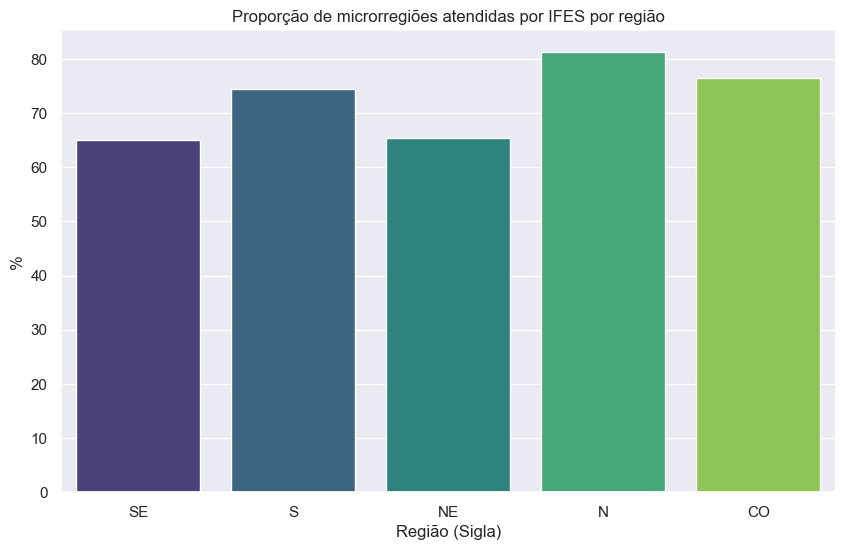

In [147]:
df_regiao= df_micro_x_ies.groupby('REGIAO').agg({'NUM_MICRO_REG': 'sum', 'POPULACAO':'sum', 'NUM_MICRO_REG_COM_IES': 'sum'}).reset_index()
df_regiao['prop_micro_com_ies'] = (df_regiao['NUM_MICRO_REG_COM_IES']/df_regiao['NUM_MICRO_REG']) * 100
print(df_regiao)
# Ordenar por proporção
df_regiao = df_regiao.sort_values(by='REGIAO', ascending=False)

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_regiao, y='prop_micro_com_ies', x='REGIAO', palette='viridis')
plt.ylabel('%')
plt.xlabel('Região (Sigla)')
plt.title('Proporção de microrregiões atendidas por IFES por região')
#plt.xticks(fontsize=8, rotation=30)
plt.show()

In [69]:
#df_micro_reg.head()

df_micro = df_micro_reg.groupby(['NOME_UF',  'Nome_Mesorregiao',  'Nome_Microrregiao']).agg({'POP_IBGE_2022': 'sum', 'COD_IBGE': 'nunique'}).reset_index()
df_micro = df_micro.rename(columns={'COD_IBGE':'NUM_MUNICIPIOS', 'POP_IBGE_2022':'POPULACAO_MICRO'})

df_ies_micro = df_cursos_ies_ibge.groupby(['NOME_UF',  'Nome_Mesorregiao', 'Nome_Microrregiao']).agg({'COD_IBGE':'nunique', 'CO_IES': 'nunique'}).reset_index()
df_ies_micro= df_ies_micro.rename(columns = {'COD_IBGE':'NUM_MUNICIPIOS_COM_IES', 'CO_IES': 'NUM_IES_MICRO'})

df_micro[~df_micro['Nome_Microrregiao'].isin(df_ies_micro['Nome_Microrregiao'])]
#.groupby('NOME_UF').count()

df_micro_x_ies = df_micro.merge(df_ies_micro, how='left', on=['NOME_UF', 'Nome_Mesorregiao','Nome_Microrregiao'])
df_micro_x_ies= df_micro_x_ies.fillna(0)

df_micro_x_ies[df_micro_x_ies['NOME_UF'] == 'Alagoas']


,NOME_UF,Nome_Mesorregiao,Nome_Microrregiao,POPULACAO_MICRO,NUM_MUNICIPIOS,NUM_MUNICIPIOS_COM_IES,NUM_IES_MICRO
5,Alagoas,Agreste Alagoano,Arapiraca,431914,10,1.00,2.00
6,Alagoas,Agreste Alagoano,Palmeira dos Índios,167883,11,1.00,2.00
7,Alagoas,Agreste Alagoano,Traipu,34282,3,0.00,0.00
8,Alagoas,Leste Alagoano,Litoral Norte Alagoano,73801,5,1.00,3.00
9,Alagoas,Leste Alagoano,Maceió,1225966,10,4.00,2.00
10,Alagoas,Leste Alagoano,Mata Alagoana,265396,16,1.00,1.00
11,Alagoas,Leste Alagoano,Penedo,119710,5,1.00,2.00
12,Alagoas,Leste Alagoano,Serrana dos Quilombos,137572,7,2.00,2.00
13,Alagoas,Leste Alagoano,São Miguel dos Campos,246947,9,0.00,0.00
14,Alagoas,Sertão Alagoano,Alagoana do Sertão do São Francisco,82149,3,2.00,2.00


Tentativa de fazer um mapa do brasil com o numero de matriculados x populacao com ajuda do chatGPT

In [148]:
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

# Carregue o shapefile das fronteiras do Brasil
brasil = gpd.read_file('BR_Pais_2022.shp')  # Substitua 'brasil_shapefile.shp' pelo caminho correto para seu shapefile
brasil


,geometry
0,"MULTIPOLYGON (((-41.82601 -2.75727, -41.82171 -2.76125, -41.82015 -2.76060, -41.81858 -2.75994, -41.81758 -2.75949, -41.81525 -2.75860, -41.81300 -2.75727, -41.81153 -2.75634, -41.81034 -2.75546, -41.80898 -2.75378, -41.80878 -2.75363, -41.80773 -2.75287, -41.80583 -2.75181, -41.80452 -2.75106, -41.80308 -2.75043, -41.80159 -2.75014, -41.80063 -2.74994, -41.79862 -2.74975, -41.79685 -2.74981, -41.79676 -2.74981, -41.79463 -2.74993, -41.79450 -2.74994, -41.79444 -2.74994, -41.79306 -2.75061, -41.79300 -2.75067, -41.79162 -2.75208, -41.78988 -2.75334, -41.78859 -2.75423, -41.78758 -2.75479, -41.78656 -2.75534, -41.78641 -2.75547, -41.78444 -2.75645, -41.78300 -2.75725, -41.78240 -2.75778, -41.78181 -2.75831, -41.78076 -2.76078, -41.77935 -2.76413, -41.77820 -2.76687, -41.77704 -2.76917, -41.77579 -2.77148, -41.77425 -2.77387, -41.77371 -2.77486, -41.77312 -2.77611, -41.77251 -2.77702, -41.77205 -2.77801, -41.77121 -2.77965, -41.77030 -2.78091, -41.76918 -2.78242, -41.76774 -2.78423, ..."


In [153]:
t2.head()


,COD_IBGE,LAT,LNG,REGIAO,SIGLA_UF,NOME_UF,Cod_Mesorregiao,Nome_Mesorregiao,Cod_Microrregiao,Nome_Microrregiao,NOME_MUNICIPIO,NUM_CURSOS,NUM_VAGAS_ANO,NUM_MATRICULADOS,POPULACAO,NUM_IES
0,1100023,-9.91,-63.03,N,RO,Rondônia,2,N (Rondônia) - Leste Rondoniense,3,Ariquemes,Ariquemes,5,165,454,100896,2
1,1100049,-11.43,-61.44,N,RO,Rondônia,2,N (Rondônia) - Leste Rondoniense,6,Cacoal,Cacoal,8,490,1255,92202,2
2,1100064,-13.13,-60.56,N,RO,Rondônia,2,N (Rondônia) - Leste Rondoniense,8,Colorado do Oeste,Colorado do Oeste,5,226,706,15747,1
3,1100106,-10.77,-65.32,N,RO,Rondônia,1,N (Rondônia) - Madeira-Guaporé,2,Guajará-Mirim,Guajará-Mirim,7,230,728,39396,2
4,1100114,-10.44,-62.48,N,RO,Rondônia,2,N (Rondônia) - Leste Rondoniense,4,Ji-Paraná,Jaru,1,40,111,52090,1


In [ ]:
#t2.head()
# Combine os dados geoespaciais com os dados das universidades
#dados_geoespaciais = brasil.merge(t2, on='codigo_ibge', how='inner')

dados_universidades_gdf = gpd.GeoDataFrame(t2, geometry=gpd.points_from_xy(t2['LNG'], t2['LAT']))


In [152]:

# Realize a junção espacial com o shapefile do Brasil
merged_data = gpd.sjoin(brasil, dados_universidades_gdf, how="inner", op="intersects")



C:\Users\giluc\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



<Axes: >

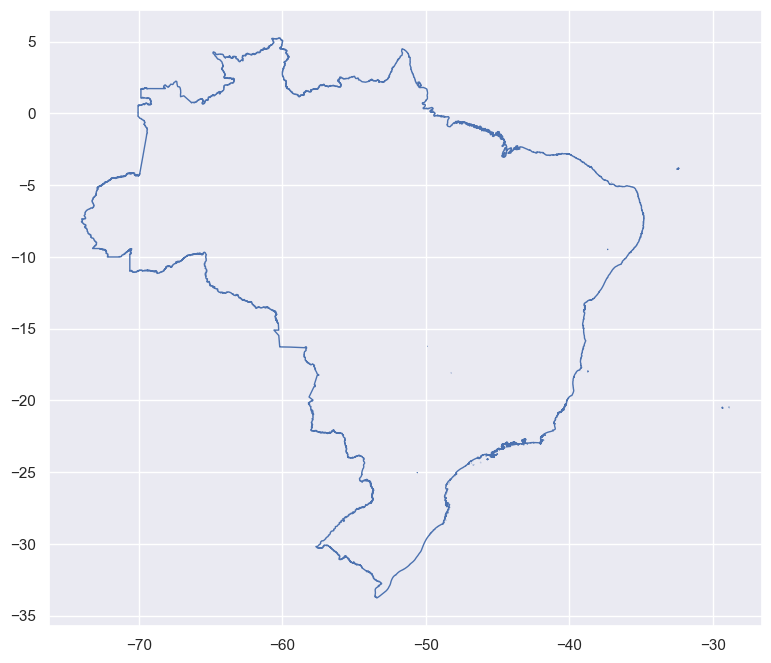

In [154]:
plt.figure(figsize=(10, 8))
brasil.boundary.plot(ax=plt.gca(), linewidth=1)


KeyboardInterrupt: 

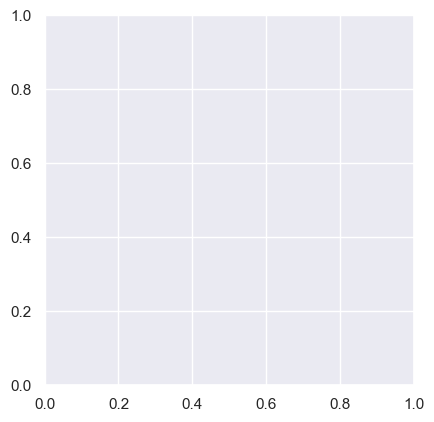

In [156]:
##aqui trava e nao mostra 
merged_data.plot(column='NUM_MATRICULADOS', cmap='YlGn', legend=True, markersize=merged_data['NUM_MATRICULADOS'] / 100, alpha=0.8)


In [ ]:
plt.title('Universidades Federais e Alunos Matriculados no Brasil')
plt.show()